In [180]:
import os
import sys

AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../AERO_LIB/'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

PyXfoil_dir = os.path.abspath(os.path.join('../Xfoil/'))
if PyXfoil_dir not in sys.path:
    sys.path.append(PyXfoil_dir)

import py_Xfoil as pxf
from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

# Задание формата шрифта для графиков
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [181]:
alpha_Ansys = np.array([-16, -12,  -8,  -4,  -2,   0,   2,   4,   8,  12,  16])
cya_Ansys = np.array([-0.61606586, -0.5541269 , -0.40776431, -0.15321114, -0.01155672, 0.13245655,  0.27776655,  0.42350608,  0.70470581,  0.9251901 , 0.90648008])

flag
flag
flag
flag
flag
flag
flag


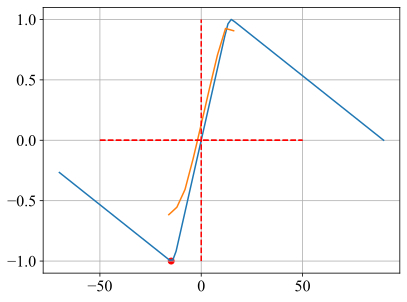

In [182]:
c_y_a_alpha = 0.07415457
delta_c_ya = 0.149294999
alpha_kr = 12.824034

def cya_non_linear(alpha, c_y_a_alpha, c_y_a_max, alpha_kr):
    '''
    Функция для нелинейного участка кривой c_y_a (alpha)
    
    Ввод: alpha: float - угол атаки, град
          c_y_a_alpha: float - производная линейного участка кривой c_y_a (alpha) на малых углах атаки, 1/град
          c_y_a_max: float - максимальное значение коэффициента c_y_a
          alpha_kr: float - значение критического угла атаки, град

    Вывод: c_y_a: float - значение коэффициента подъемной силы на нелинейном участке
    '''
    
    # Первый участок - парабола касается линейного участка кривой c_y_a (alpha)
    # Условие для построения параболы: 1. касание линейного участка слева
    #                                  2. равенство значений прямой и параболы в точке касания
    #                                  3. вершина параболы по y лежит в точке c_y_a_max
    #                                  4. вершина параболы по x лежит в точке alpha_kr

    # дискриминант
    D = (2*delta_c_ya - 2*c_y_a_max)**2 - 4*c_y_a_alpha*(2*c_y_a_max*alpha_kr - c_y_a_alpha*alpha_kr**2 - 2*delta_c_ya*alpha_kr)
    
    # координата по alpha точки касания параболы и прямой
    x0 = (-(2*delta_c_ya - 2 * c_y_a_max) - np.sqrt(D)) / 2 / c_y_a_alpha

    # коэффициент a в уравнении для параболы
    a = c_y_a_alpha / (2 * (x0 - alpha_kr))
    # коэффициент b в уравнении для параболы
    b = -2*a*alpha_kr
    # коэффициент c в уравнении для параболы
    c = c_y_a_max + a*alpha_kr**2

    # уравнение искомой параболы
    def parab_new(x):
        return (a*x**2 + b*x + c)
    
    # Прямая второго участка - касательна к параболе и приходит в 0 на угле 90 градусов
    
    # координаты конечной точки прямой
    x2 = 90
    y2 = 0
    
    # дискриминант
    D1 = 4*(x2**2)*(a**2) - 4 * a * (y2 - b*x2-c)

    # координата точки касания прямой к параболе
    x1 = (2*x2*a + np.sqrt(D1)) / 2 / a
    # коэффициент k в уравнении прямой
    k = 2*a*x1 + b
    # коэффициент d в уравнении прямой
    d = - k*x2 + y2

    # уравнение искомой прямой
    def line(xx):
        return k*xx + d

    # результат
    if alpha<0:
        if np.abs(alpha) < np.abs(x0):
            return 2 * delta_c_ya - (np.abs(alpha) * c_y_a_alpha + delta_c_ya)
        if np.abs(x0) <= np.abs(alpha) <= np.abs(x1):
            return 2 * delta_c_ya - parab_new(np.abs(alpha))
        if np.abs(alpha) > np.abs(x1):
            return 2 * delta_c_ya - line(np.abs(alpha))
    else:
        if np.abs(alpha) < np.abs(x0):
            return alpha * c_y_a_alpha + delta_c_ya
        if np.abs(x0) <= np.abs(alpha) <= np.abs(x1):
            return parab_new(alpha)
        if np.abs(alpha) > np.abs(x1):
            return line(alpha)

alphas = np.linspace(-70, 90, 101)
cya_s = []

# cya_non_linear(-5, 1, c_y_a_alpha, alpha_kr)

for aa in alphas:
    cya_s.append(cya_non_linear(aa, c_y_a_alpha, 1, alpha_kr + 2))

plt.plot(alphas, cya_s)
plt.plot(alpha_Ansys, cya_Ansys)
# print(alphas)
plt.scatter(- alpha_kr - 2, - 1, color = 'red')
plt.hlines(0, -50, 50, color = 'red', ls ='--')
plt.hlines(delta_c_ya, -50, 50, color = 'red', ls ='--')
plt.vlines(0, -1, 1, color = 'red', ls ='--')
plt.grid()